
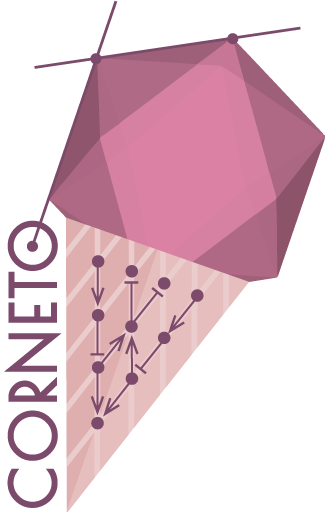

In [122]:
import corneto as cn
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

import warnings

from corneto.methods.metabolism import evaluate_gpr_expression
from corneto._data import Data
from corneto.methods.future.imat import MultiSampleIMAT
sys.path.append(os.path.abspath('..'))

from Scripts import Functions as custom

cn.info()

## Load and preprocess Dataset

In [123]:
warnings.simplefilter("ignore", FutureWarning)

In [124]:
G = cn.io.import_cobra_model("test_data/ecoli_core.xml")
df_expr = pd.read_csv("test_data/ecoli_example_data.csv")
metadata = pd.read_csv("test_data/ecoli_example_metadata.csv")

In [125]:
dataset = custom.average_expression_by_condition(df_expr, metadata)

## Discretize expression

Before mapping data using GPR rules and using iMAT. Expression is first pooled from all samples and then discritized into low, neutral and high. Usually this is performed by manual inspection of the distribution to determine thresholds. However, this process can be fiddly and subjective, so 2 automated approaches are defined : 
    (1) quantile based cut
    (2) Gaussian Mixture Model (GMM)

Make sure to inspect the plots after running both approaches for sanity check before going forward with GPR assignment

In [126]:
quantile_based = custom.discretize_expression(df = dataset, method="quantile", pool=False)

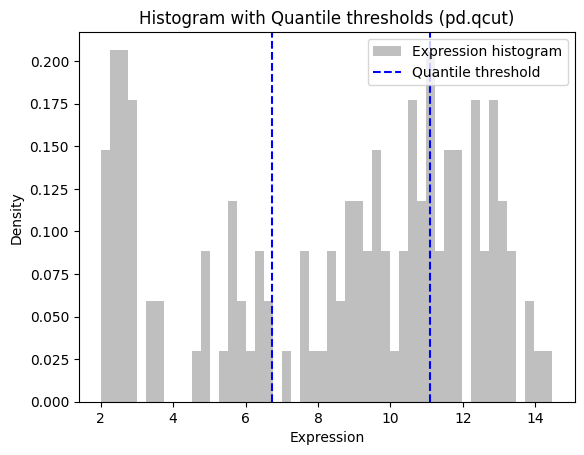

In [12]:
custom.plot_quantile_discretization(data=quantile_based.expression[quantile_based['Condition'] == "Control"].values.flatten(),n_components=3)

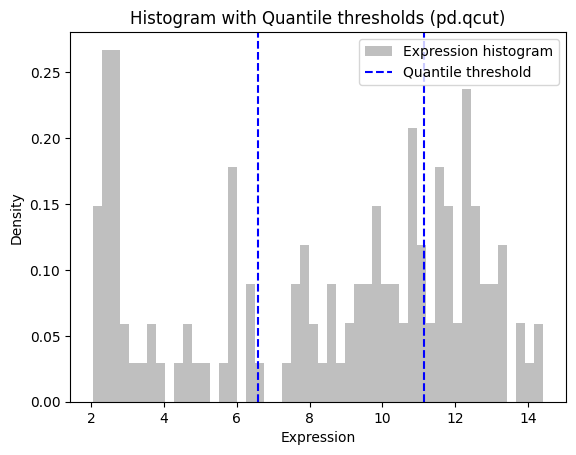

In [13]:
custom.plot_quantile_discretization(data=quantile_based.expression[quantile_based['Condition'] == "Treated"].values.flatten(),n_components=3)

In [121]:
gmm_based = custom.discretize_expression(df = dataset, method="gmm", pool=False)

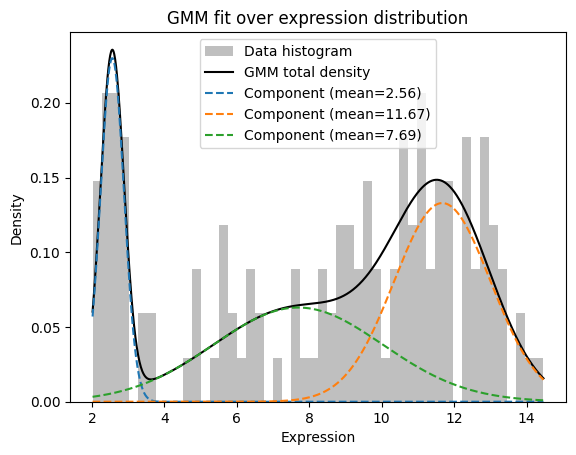

In [21]:
custom.plot_gmm_fit(gmm= gmm_based['gmm_results']['Control'][1],
                    data = gmm_based['updated_df'].expression[gmm_based['updated_df']['Condition'] == "Control"].values.flatten())

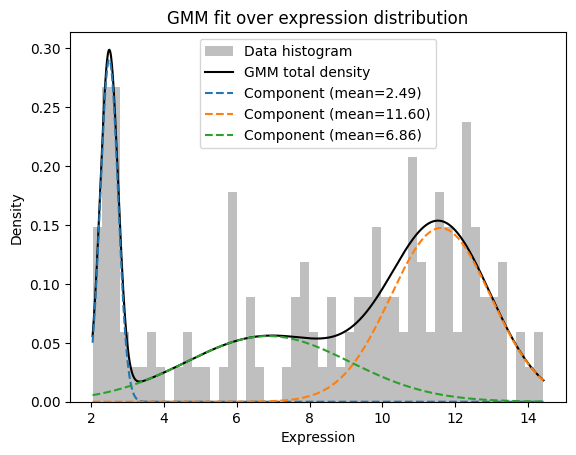

In [22]:
custom.plot_gmm_fit(gmm= gmm_based['gmm_results']['Treated'][1],
                    data = gmm_based['updated_df'].expression[gmm_based['updated_df']['Condition'] == "Treated"].values.flatten())

## Mapping data using Gene-Protein-Reaction (GPR) rules

We will use the reaction scores to create a `Data` object. The id corresponds to the reaction id of the prior knowledge network, and the value to the reaction score. We indicate that these features map to edges (reactions) with `mapping = edge`. Note that if `mapping = none`, then it will be assumed that the dataset contains genes, and automatic GPR will be performed to translate from genes to reaction scores.

In [131]:
conds = quantile_based['Condition'].unique()
data = {}
for cond in conds:
    cond_df = quantile_based[quantile_based['Condition'] == cond]
    cond_df.score = cond_df.score.astype(int)
    values = cond_df[["gene", "score"]].set_index("gene").to_dict()["score"]
    e = evaluate_gpr_expression(G.get_attr_from_edges("GPR"), values)

    feats = dict()
    for edge, val in zip(G.get_attr_from_edges("id"), e):
        feats[edge] = {"value": val, "mapping": "edge"}
    data[cond] = feats

data = Data.from_cdict(data)
data

/tmp/ipykernel_124472/3939651823.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cond_df.score = cond_df.score.astype(int)
/tmp/ipykernel_124472/3939651823.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cond_df.score = cond_df.score.astype(int)


Data(n_samples=2, n_feats=[91 91])

In [132]:
pd.DataFrame({"id": G.get_attr_from_edges("id"), "score": e})

,id,score
0,EX_ac_b,0
1,EX_akg_b,0
2,EX_co2_b,0
3,EX_etoh_b,0
4,EX_for_b,0
...,...,...
86,TALA,1
87,THD2,0
88,TKT1,0
89,TKT2,0


## Run iMAT

In [151]:
# eps is the min absolute flux value that we will consider
# for reactions with positive scores, i.e., if a reaction
# with a positive score is included in the context specific
# metabolic network, it has to be able to carry an absolute
# metabolic flux value above eps.
eps = 1e-2

# We will also add a small penalty to make networks sparser.
# When we have more than 1 sample, this parameter controls
# the regularization across samples, blocking entire groups
# of reactions across samples. Here, we are just penalizing
# the inclusion of reactions not needed to fit the reaction
# scores
m = MultiSampleIMAT(lambda_reg=1e-3, eps=eps, use_bigm_constraints=False)
preprocessed_data = m.preprocess(G, data)
P = m.build(preprocessed_data[0], preprocessed_data[1])
P.expr

{'_flow': _flow: Variable((91, 2), _flow),
 '_flow_ineg': _flow_ineg: Variable((91, 2), _flow_ineg, boolean=True),
 '_flow_ipos': _flow_ipos: Variable((91, 2), _flow_ipos, boolean=True),
 'edge_has_flux': edge_has_flux: Variable((91, 2), edge_has_flux, boolean=True),
 'edge_has_flux_OR': edge_has_flux_OR: Variable((91,), edge_has_flux_OR, boolean=True),
 'flow': _flow: Variable((91, 2), _flow)}

In [152]:
P.solve(solver="scipy", verbosity=0)

Problem(Minimize(Expression(AFFINE, UNKNOWN, ())), [Inequality(Constant(CONSTANT, UNKNOWN, (91, 2))), Inequality(Variable((91, 2), _flow)), Equality(Expression(AFFINE, UNKNOWN, (77, 2)), Constant(CONSTANT, ZERO, ())), Inequality(Expression(AFFINE, UNKNOWN, (91, 2))), Inequality(Variable((91, 2), _flow)), Inequality(Expression(AFFINE, NONNEGATIVE, (91, 2))), Equality(Expression(AFFINE, NONNEGATIVE, (72, 2)), Constant(CONSTANT, ZERO, ())), Inequality(Expression(AFFINE, UNKNOWN, (91, 2))), Inequality(Variable((91, 2), _flow)), Inequality(Expression(AFFINE, NONNEGATIVE, (91,))), Inequality(Variable((91,), edge_has_flux_OR, boolean=True))])

In [153]:
for o in P.objectives:
    print(o.value)

1.0
2.0
1.0
2.0
55.0


## Post iMAT

In [157]:
df_sol = pd.DataFrame(
    P.expr.flow.value, index=G.get_attr_from_edges("id"), columns=["Control_flux", "Treated_flux"]
)
df_sol

,Control_flux,Treated_flux
EX_ac_b,3.941851,3.941851
EX_akg_b,0.000000,0.000000
EX_co2_b,0.000000,0.000000
EX_etoh_b,4.071907,4.071907
EX_for_b,8.261913,8.261913
...,...,...
TALA,0.010000,0.010000
THD2,0.830454,0.830454
TKT1,0.010000,0.010000
TKT2,-0.010000,-0.010000


<Axes: >

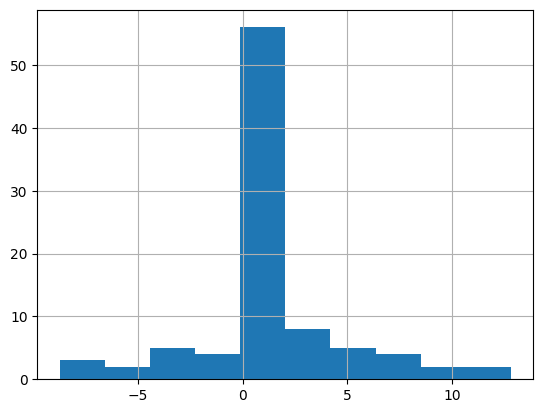

In [160]:
df_sol['Treated_flux'].hist()

In [168]:
# Extract the context specific network
G_ctx = G.edge_subgraph(np.flatnonzero(P.expr.edge_has_flux.value[:,0]))
G_ctx.shape


(56, 55)

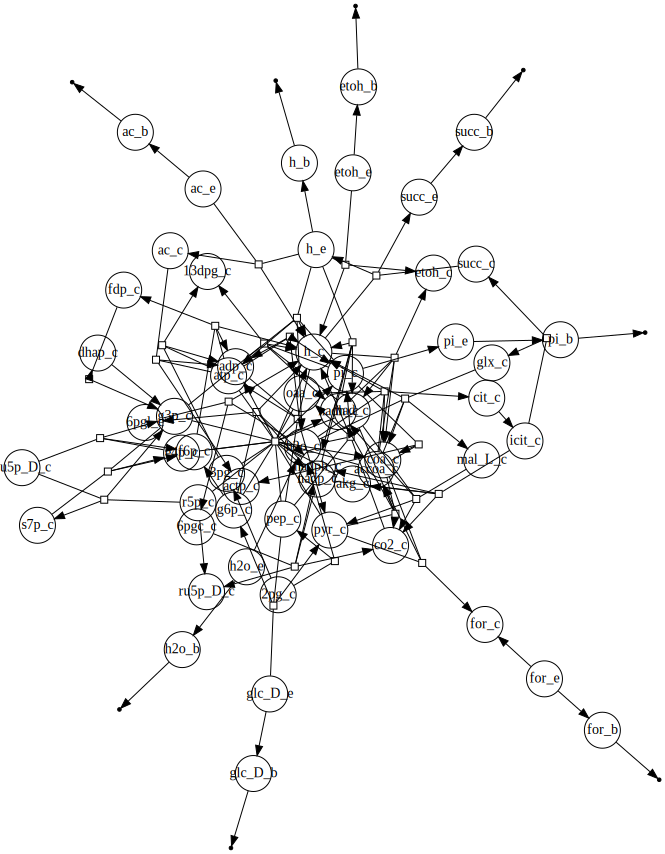

In [169]:
G_ctx.plot(layout="neato")